In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys
from scipy import special, stats
from multiprocessing import get_context

/home/sangrey/anaconda3/envs/volprice2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
bounds = {'zeta1': {'max': -10, 'min':-30, 'dim':15}, 'phi': {'max': 0, 'min':-1, 'dim':25}, 
          'zeta2': {'max':4, 'min': 0, 'dim':20}}
innov_dim = 3000

In [5]:
vl.__version__

'0.05.01-py37_0'

## Load the data

In [6]:
ll  -t -h ../data

lrwxrwxrwx 1 sangrey 46 Oct  8 12:45 ../data -> /home/sangrey/External/RiskPriceInferenceData//


In [7]:
data = pd.read_hdf('../data/spy_daily_estimates_heavy.hdf')

In [8]:
data.mean()

rtn    0.004463
vol    0.058242
mu     0.059183
dtype: float64

In [9]:
data.transform(lambda x: np.sqrt(x) if x.name in ('vol', 'mu') else x).cov()

rtn       vol        mu
rtn  0.070565 -0.004806  0.000358
vol -0.004806  0.019283  0.016200
mu   0.000358  0.016200  0.017273

In [10]:
data.corr()

rtn       vol        mu
rtn  1.000000 -0.090481  0.030017
vol -0.090481  1.000000  0.802493
mu   0.030017  0.802493  1.000000

In [11]:
data.describe()

rtn          vol           mu
count  5159.000000  5159.000000  5159.000000
mean      0.004463     0.058242     0.059183
std       0.265641     0.143270     0.130877
min      -3.116810     0.001233     0.004720
25%      -0.100022     0.013920     0.016717
50%       0.014012     0.025535     0.028102
75%       0.121032     0.053926     0.055724
max       2.280964     4.218808     3.345526

In [12]:
data.describe()

rtn          vol           mu
count  5159.000000  5159.000000  5159.000000
mean      0.004463     0.058242     0.059183
std       0.265641     0.143270     0.130877
min      -3.116810     0.001233     0.004720
25%      -0.100022     0.013920     0.016717
50%       0.014012     0.025535     0.028102
75%       0.121032     0.053926     0.055724
max       2.280964     4.218808     3.345526

In [13]:
data_for_plot = data.copy()
data_for_plot.vol *= 252**2
data_for_plot.rtn *= 252
data_for_plot.mu *= 252**2

In [14]:
data_for_plot.mean()

rtn       1.124584
vol    3698.587740
mu     3758.362099
dtype: float64

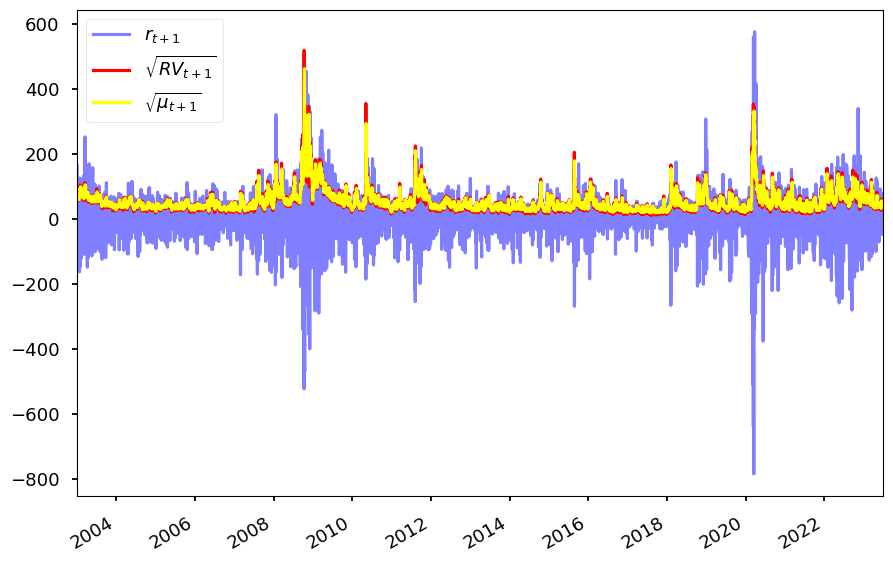

In [15]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{RV_{t+1}}$', color='red')
data_for_plot['mu'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\mu_{t+1}}$', color='yellow')
ax1.legend()
ax1.set_xlabel("")
fig1.savefig('../doc/figures/time_series.tmp.png', pad_inches=0, bbox_inches='tight')

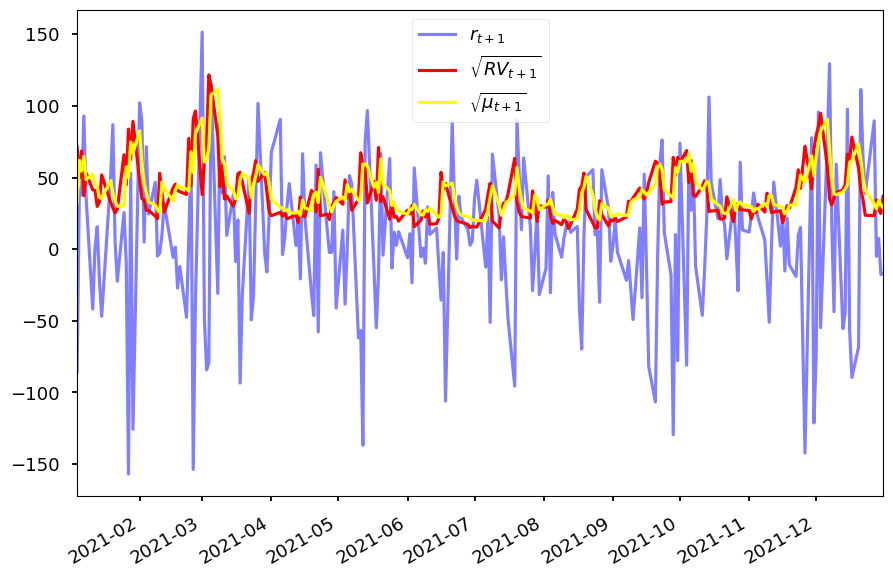

In [16]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot.loc['2021', 'rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot.loc['2021', 'vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{RV_{t+1}}$', color='red')
data_for_plot.loc['2021', 'mu'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\mu_{t+1}}$', color='yellow')
ax1.legend()
ax1.set_xlabel("")
fig1.savefig('../doc/figures/time_series_2021.tmp.png', pad_inches=0, bbox_inches='tight')

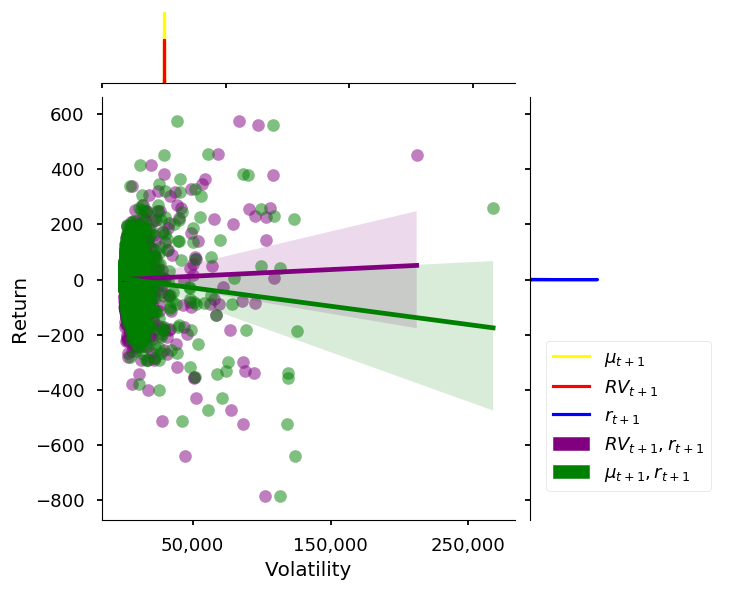

In [17]:
joint_grid = sns.JointGrid(x='mu', y='rtn', data=data_for_plot)
joint_grid.plot_joint(sns.regplot, color='purple', scatter_kws={"alpha":.5})
sns.regplot(x=data_for_plot['vol'], y=data_for_plot['rtn'], ax=joint_grid.ax_joint, color='green',
            scatter_kws={"alpha":.5})
sns.kdeplot(data['mu'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='yellow', label='$\mu_{t+1}$')
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red',
            label='$RV_{t+1}$')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue',
            vertical=True, label='$r_{t+1}$')
joint_grid.set_axis_labels(xlabel="Volatility", ylabel='Return')
joint_grid.ax_marg_x.set_xticks(list(joint_grid.ax_marg_x.get_xticks())[::2])
handles_x, labels_x = joint_grid.ax_marg_x.get_legend_handles_labels()
handles_y, labels_y = joint_grid.ax_marg_y.get_legend_handles_labels()
patch1 = mpl.patches.Patch(color='purple', label='$RV_{t+1}, r_{t+1}$')
patch2 = mpl.patches.Patch(color='green', label='$\mu_{t+1}, r_{t+1}$')
joint_grid.ax_joint.get_figure().legend(handles=handles_x+handles_y+[patch1, patch2], loc='lower right',
                                       bbox_to_anchor=(1.2, .15))
joint_grid.ax_marg_x.set_xticklabels(["{:,.0f}".format(val) for val in joint_grid.ax_marg_x.get_xticks()])
joint_grid.savefig('../doc/figures/joint_dist.tmp.png', pad_inches=0, bbox_inches='tight')

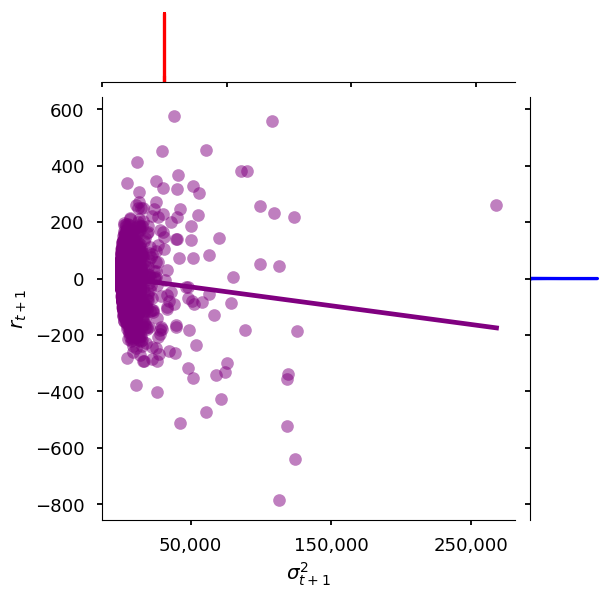

In [18]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data_for_plot) #, xlim=[-.1, 3], ylim=[-2, 2])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.ax_marg_x.set_xticks(list(joint_grid.ax_marg_x.get_xticks())[::2])

joint_grid.ax_marg_x.set_xticklabels(["{:,.0f}".format(val) for val in joint_grid.ax_marg_x.get_xticks()])
joint_grid.savefig('../doc/figures/joint_dist.tmp.png', pad_inches=0, bbox_inches='tight')

In [19]:
data_for_plot.describe()

rtn            vol             mu
count  5159.000000    5159.000000    5159.000000
mean      1.124584    3698.587740    3758.362099
std      66.941608    9098.226926    8311.226137
min    -785.436025      78.322546     299.722288
25%     -25.205521     883.959361    1061.576160
50%       3.531094    1621.573582    1784.611563
75%      30.499981    3424.525309    3538.703642
max     574.802898  267911.173110  212454.275489

In [20]:
stats.kurtosis(data_for_plot, fisher=False)

array([ 16.806, 205.427, 140.178])

In [21]:
stats.skew(data_for_plot)

array([-0.575, 11.246,  9.565])

In [22]:
data_for_plot.corr()

rtn       vol        mu
rtn  1.000000 -0.090481  0.030017
vol -0.090481  1.000000  0.802493
mu   0.030017  0.802493  1.000000

## We now estimate the volatility paramters.

In [23]:
omega, omega_cov = vl.estimate_params_strong_id(data[['rtn', 'mu']].rename(columns={'mu':'vol'}), bounds=bounds)

In [24]:
omega

{'gamma': 0.005044359467325101,
 'beta': -0.10872968898398674,
 'psi': 0.09683314547903682,
 'xi': 1.1320929463206835,
 'log_both': -5.3510165402267225,
 'log_scale': -4.233832566321864,
 'logit_rho': 2.3691888277713913,
 'phi': -0.0021461662001441067,
 'zeta1': -30.0,
 'zeta2': 0.5343229283816903}

In [25]:
estimates, covariance = vl.estimate_params(data[['rtn', 'mu']].rename(columns={'mu':'vol'}), *vl.compute_vol_gmm(data.vol))

In [26]:
estimates

{'gamma': 0.005044359467325101,
 'beta': -0.10872968898398674,
 'psi': 0.09683314547903682,
 'xi': 1.1320929463206835,
 'log_both': -4.573398443649397,
 'log_scale': -3.4244606589446644,
 'logit_rho': 1.4461574362440945}

## I compute the point estimates and confidence intervals for the volatility parameters.

### c

In [27]:
(252 * np.exp(estimates['log_scale']),
252 * np.exp(estimates['log_scale'] - 1.96 * covariance.loc['log_scale', 'log_scale']**.5),
 252 * np.exp(estimates['log_scale'] + 1.96 * covariance.loc['log_scale', 'log_scale']**.5))


(8.206843903681232, 4.842768369506898, 13.907806799821767)

### delta

In [28]:
log_mean = estimates['log_both'] - estimates['log_scale']
log_var = (covariance.loc['log_scale', 'log_scale'] + covariance.loc['log_both', 'log_both'] 
           - 2 * covariance.loc['log_scale', 'log_both'])
(252 * np.exp(log_mean),
 252 * np.exp(log_mean - 1.96 * log_var**.5),
 252 * np.exp(log_mean + 1.96 * log_var**.5)
)

(79.87726769214557, 46.467789775024535, 137.30753980022524)

### rho

In [29]:
mean = estimates['logit_rho']
std = covariance.loc['logit_rho', 'logit_rho']**.5
(special.expit(mean), special.expit(mean - 1.96 * std), special.expit(mean + 1.96*std))

(0.8094063551426683, 0.7271183739208855, 0.8712732470000396)

In [30]:
covariance

beta     gamma  log_both  log_scale  logit_rho       psi  \
beta       0.031040 -0.000055  0.000000   0.000000   0.000000 -0.030122   
gamma     -0.000055  0.000008  0.000000   0.000000   0.000000 -0.000089   
log_both   0.000000  0.000000  0.020462   0.008248  -0.031105  0.000000   
log_scale  0.000000  0.000000  0.008248   0.072427   0.004235  0.000000   
logit_rho  0.000000  0.000000 -0.031105   0.004235   0.056553  0.000000   
psi       -0.030122 -0.000089  0.000000   0.000000   0.000000  0.035336   
xi         0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   

                 xi  
beta       0.000000  
gamma      0.000000  
log_both   0.000000  
log_scale  0.000000  
logit_rho  0.000000  
psi        0.000000  
xi         0.000788

In [31]:
data.vol.sort_values(ascending=True).head()

date_time
2017-08-07    0.001233
2017-09-14    0.002147
2017-09-22    0.002169
2017-10-03    0.002182
2017-12-26    0.002217
Name: vol, dtype: float64

In [32]:
omega2, omega_cov2 = vl.estimate_params(data)